# Comparaison des prédictions des différentes lignées cellulaires et du modèle estimé par apprentissage de transfert sur certaines séquences de test

In [1]:
import json
import numpy as np
import pandas as pd
import statsmodels.api as sm

In [2]:
import h5py
import cooler

In [3]:
import matplotlib.pyplot as plt

In [4]:
predpath = "/home/bureau/projects/def-bureau/bureau/ran-donnees/PredictNeuronHi-C/akita_pred_test/"
predfile = predpath + "preds.h5"

In [5]:
pred = h5py.File(predfile, 'r')
pred

<HDF5 file "preds.h5" (mode r)>

In [6]:
pred.keys()

<KeysViewHDF5 ['preds']>

In [7]:
pred['preds'].shape

(6667, 99681, 5)

In [8]:
targetfile = "/home/bureau/projects/def-bureau/bureau/distiller/iPSC/data/1m/seqs_cov/0.h5"

In [9]:
targets = h5py.File(targetfile, 'r')
targets

<HDF5 file "0.h5" (mode r)>

In [10]:
# Les données de tests sont les 6667 (pred['preds'].shape[0]) dernières
test_targets = targets['targets'][targets['targets'].shape[0]-pred['preds'].shape[0]:,]

In [11]:
test_targets.shape

(6667, 99681)

In [12]:
predf = h5py.File('pred_final.h5', 'r')
predf

<HDF5 file "pred_final.h5" (mode r)>

In [13]:
predf.keys()

<KeysViewHDF5 ['pred_final']>

In [14]:
predf['pred_final'].shape

(6667, 99681)

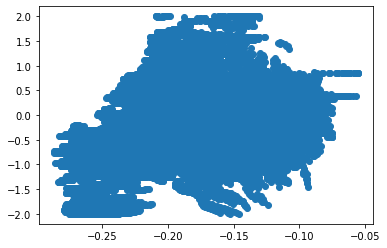

In [16]:
plt.scatter(predf['pred_final'][1,:], test_targets[1,:])
plt.show()

In [18]:
hic_targets = pd.read_csv('/home/bureau/projects/def-bureau/basenji/manuscripts/akita/data/targets.txt',sep='\t')
hic_targets

,index,identifier,file,clip,description
0,0,HFF,../../data/coolers/Krietenstein2019/HFF_hg38_4...,2,HFF
1,1,H1hESC,../../data/coolers/Krietenstein2019/H1hESC_hg3...,2,H1hESC
2,2,GM12878,../../data/coolers/Rao2014/GM12878_inSitu_MboI...,2,GM12878
3,3,IMR90,../../data/coolers/Rao2014/IMR90_inSitu_MboI_a...,2,IMR90
4,4,HCT116,../../data/coolers/Rao2017/Unsynchronized_all....,2,HCT116


## Décalage entre les cibles / Lag between targets

In [15]:
params_file = "/home/bureau/projects/def-bureau/basenji/manuscripts/akita/params.json"
with open(params_file) as params_open:
    params = json.load(params_open)
    params_model = params['model']
    params_train = params['train']

seq_length = params_model['seq_length']
target_length = params_model['target_length']
target_crop = params_model['target_crop']
hic_diags = 2
target_length_cropped = target_length - 2*target_crop
# Longueur d'une cible dans la séquence / length of a target in the sequence
n = target_length_cropped - hic_diags
# Longueur d'un vecteur cible extrait du triangle supérieur de la matrice de contacts 3D / 
# length of a target vector extracted from the upper triangle of the 3D contact matrix
tlen = n * (n+1) // 2
tlen

99681

In [16]:
# Nombre de bacs de séquences par lequel on décale / striding by this number of sequence bins
k = 16
# Décalage dans le vecteur cible / Lag in target vector corresponding to striding in sequence bins
decal = []
for h in range(1,10):
    decal.append(int(k*(n-h/2*(h*k-1)/2)))
decal

[7076, 6888, 6572, 6128, 5556, 4856, 4028, 3072, 1988]

### Examen des mêmes points de contact dans plusieurs cible / Inspection of same contact points in multiple targets

In [19]:
# Les valeurs sont très différentes / the values differ greatly
display([test_targets[1,0],test_targets[0,decal[0]]])
display([test_targets[2,0],test_targets[1,decal[0]],test_targets[0,decal[0]+decal[1]]])
display([test_targets[3,0],test_targets[2,decal[0]],test_targets[1,decal[0]+decal[1]],test_targets[0,decal[0]+decal[1]+decal[2]]])

[0.3306, 0.839]

[-0.2554, -0.4329, -0.4717]

[0.273, -0.0847, 0.01675, 0.2817]

In [20]:
# 10e bac / 10th bin
display([test_targets[1,10],test_targets[0,10+decal[0]]])
display([test_targets[2,10],test_targets[1,10+decal[0]],test_targets[0,10+decal[0]+decal[1]]])
display([test_targets[3,10],test_targets[2,10+decal[0]],test_targets[1,10+decal[0]+decal[1]],test_targets[0,10+decal[0]+decal[1]+decal[2]]])

[0.556, -0.2457]

[-0.1054, -0.936, 0.4722]

[0.2878, 0.1923, -0.2307, 0.3733]

## Trouver une valeur égale dans une autre séquence

In [28]:
tmp = list(abs(test_targets[0,]-test_targets[1,0])<0.0001)
tmp.index(True)

7362

In [29]:
[test_targets[1,0],test_targets[0,tmp.index(True)]]

[0.3306, 0.3306]

In [88]:
tmp = list(abs(test_targets[10,]-test_targets[13,4])<0.0001)
tmp.index(True)

ValueError: True is not in list

In [38]:
index_vec = []
for j in range(14):
    tmp = list(abs(test_targets[j,]-test_targets[14,2])<0.0001)
    index_vec.append(tmp.index(True))
index_vec

[57785,
 31441,
 78397,
 52731,
 32963,
 32,
 20337,
 35062,
 77536,
 57538,
 5320,
 85196,
 97240,
 46432]

In [39]:
len(index_vec)

14

In [41]:
display(test_targets[14,2])
for j in range(len(index_vec)):
    display(test_targets[j,index_vec[j]])

-0.37

-0.37

-0.37

-0.37

-0.37

-0.37

-0.37

-0.37

-0.37

-0.37

-0.37

-0.37

-0.37

-0.37

-0.37

In [42]:
# Extraction des prédictions originales d'Akita
pred_orig = np.zeros((len(index_vec)+1,pred['preds'].shape[2]))
for j in range(len(index_vec)):
    pred_orig[j] = pred['preds'][j,index_vec[j],]
pred_orig[len(index_vec)] = pred['preds'][len(index_vec),2,]
pred_orig

array([[-0.09393311, -0.04452515, -0.04119873, -0.01849365, -0.09191895],
       [-0.00667572, -0.0059967 , -0.06256104, -0.04345703, -0.03115845],
       [-0.7890625 , -0.61865234, -0.56689453, -0.85839844, -0.49926758],
       [ 0.25146484,  0.18322754,  0.07702637,  0.14941406,  0.03613281],
       [-0.64453125, -0.49121094, -0.36035156, -0.58886719, -0.34521484],
       [ 0.08581543,  0.03799438,  0.0612793 ,  0.10583496,  0.0164032 ],
       [ 0.18933105,  0.17810059,  0.09881592,  0.1607666 ,  0.08172607],
       [ 0.01045227, -0.07849121,  0.01823425,  0.02453613, -0.08227539],
       [-0.17077637, -0.15112305, -0.18835449, -0.25390625, -0.13818359],
       [ 0.24169922,  0.2010498 ,  0.13232422,  0.19689941,  0.09301758],
       [-0.05703735, -0.02513123, -0.020401  ,  0.02796936, -0.05691528],
       [-0.23120117, -0.16455078, -0.16894531, -0.24523926, -0.18737793],
       [-0.2076416 , -0.13452148, -0.16357422, -0.21533203, -0.13012695],
       [-0.0440979 , -0.05227661, -0.0

In [43]:
pred_transfer = []
for j in range(len(index_vec)):
    pred_transfer.append(predf['pred_final'][j,index_vec[j]])
pred_transfer.append(predf['pred_final'][len(index_vec),2])
pred_transfer

[-0.11021045853544822,
 -0.11978075691187565,
 -0.173233458239634,
 -0.11203969934559377,
 -0.18929274570133922,
 -0.13185096171264996,
 -0.15572637053157046,
 -0.10211058671630995,
 -0.11911817696150162,
 -0.1432637611979502,
 -0.12347247299202585,
 -0.1618091088178983,
 -0.1574123923732294,
 -0.16171607992485448,
 -0.08314477456245384]

In [44]:
pred_dat = pd.DataFrame(pred_orig,columns=hic_targets['identifier'])
pred_dat["Neuron"] = pred_transfer
pred_dat

identifier,HFF,H1hESC,GM12878,IMR90,HCT116,Neuron
0,-0.093933,-0.044525,-0.041199,-0.018494,-0.091919,-0.110210
1,-0.006676,-0.005997,-0.062561,-0.043457,-0.031158,-0.119781
2,-0.789062,-0.618652,-0.566895,-0.858398,-0.499268,-0.173233
3,0.251465,0.183228,0.077026,0.149414,0.036133,-0.112040
4,-0.644531,-0.491211,-0.360352,-0.588867,-0.345215,-0.189293
5,0.085815,0.037994,0.061279,0.105835,0.016403,-0.131851
6,0.189331,0.178101,0.098816,0.160767,0.081726,-0.155726
7,0.010452,-0.078491,0.018234,0.024536,-0.082275,-0.102111
8,-0.170776,-0.151123,-0.188354,-0.253906,-0.138184,-0.119118
9,0.241699,0.201050,0.132324,0.196899,0.093018,-0.143264


In [52]:
# Biais
bias = pred_dat.mean() - test_targets[len(index_vec),2]
bias

identifier
HFF        0.274515
H1hESC     0.293392
GM12878    0.284233
IMR90      0.263152
HCT116     0.271565
Neuron     0.233838
dtype: float64

In [53]:
# Biais estimé avec la médiane
bias_med = pred_dat.median() - test_targets[len(index_vec),2]
bias_med

identifier
HFF        0.326019
H1hESC     0.325592
GM12878    0.328918
IMR90      0.351624
HCT116     0.287842
Neuron     0.238266
dtype: float64

In [47]:
var = pred_dat.var()
var

identifier
HFF        0.086197
H1hESC     0.051619
GM12878    0.034332
IMR90      0.084854
HCT116     0.024537
Neuron     0.000883
dtype: float64

In [54]:
# MSE
bias*bias + var

identifier
HFF        0.161555
H1hESC     0.137698
GM12878    0.115120
IMR90      0.154103
HCT116     0.098284
Neuron     0.055563
dtype: float64

In [49]:
# Corrélation
pred_dat.corr()

identifier,HFF,H1hESC,GM12878,IMR90,HCT116,Neuron
identifier,,,,,,
HFF,1.000000,0.991376,0.974111,0.982540,0.982498,0.587104
H1hESC,0.991376,1.000000,0.966883,0.977873,0.987873,0.539395
GM12878,0.974111,0.966883,1.000000,0.992617,0.972311,0.510630
IMR90,0.982540,0.977873,0.992617,1.000000,0.981034,0.585399
HCT116,0.982498,0.987873,0.972311,0.981034,1.000000,0.541167
Neuron,0.587104,0.539395,0.510630,0.585399,0.541167,1.000000


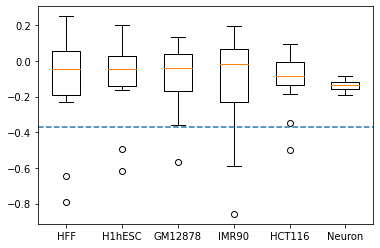

In [50]:
plt.boxplot(pred_dat,labels=pred_dat.columns)
plt.axhline(y=test_targets[len(index_vec),2], ls='--')
plt.show()

In [51]:
# Test de Wilcoxon
from scipy import stats
stats.wilcoxon(pred_dat["Neuron"],pred_dat["HCT116"])

WilcoxonResult(statistic=33.0, pvalue=0.12515345696288432)

In [55]:
stats.wilcoxon(pred_dat["Neuron"],pred_dat["GM12878"])

WilcoxonResult(statistic=34.0, pvalue=0.13975586593901426)

## Comparaison visuelle des prédictions aux cibles

In [16]:
sequences = pd.read_csv('/home/bureau/projects/def-bureau/bureau/distiller/iPSC/data/1m/sequences.bed',sep='\t',  names=['chr','start','stop','type'])
sequences_test = sequences.iloc[  sequences['type'].values=='test']
sequences_test.reset_index(inplace=True, drop=True)

In [17]:
fig2_examples = [   'chr12:106084352-107132928',
                    'chr11:90097664-91146240',
                    'chr15:42508288-43556864' ]
fig2_inds = []
for seq in fig2_examples:
    print(seq)
    chrm,start,stop = seq.split(':')[0], seq.split(':')[1].split('-')[0], seq.split(':')[1].split('-')[1]
    test_ind = np.where( (sequences_test['chr'].values== chrm) *
                         (sequences_test['start'].values== int(start))*
                         (sequences_test['stop'].values==  int(stop ))  )[0][0]
    fig2_inds.append(test_ind)
fig2_inds

chr12:106084352-107132928
chr11:90097664-91146240
chr15:42508288-43556864


[354, 1043, 3357]

In [22]:
### for converting from flattened upper-triangluar vector to symmetric matrix  ###
from cooltools.lib.numutils import set_diag

def from_upper_triu(vector_repr, matrix_len, num_diags):
    z = np.zeros((matrix_len,matrix_len))
    triu_tup = np.triu_indices(matrix_len,num_diags)
    z[triu_tup] = vector_repr
    for i in range(-num_diags+1,num_diags):
        set_diag(z, np.nan, i)
    return z + z.T

 
chr12:106084352-107132928


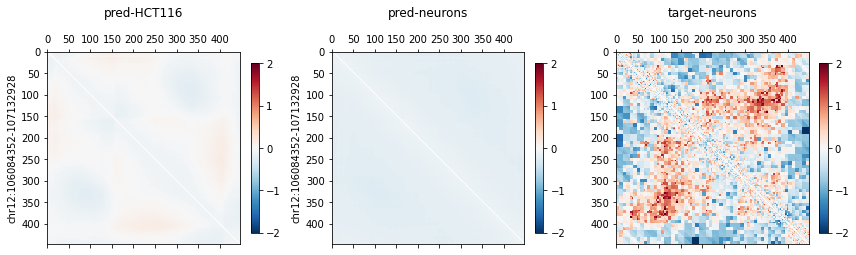

 
chr11:90097664-91146240


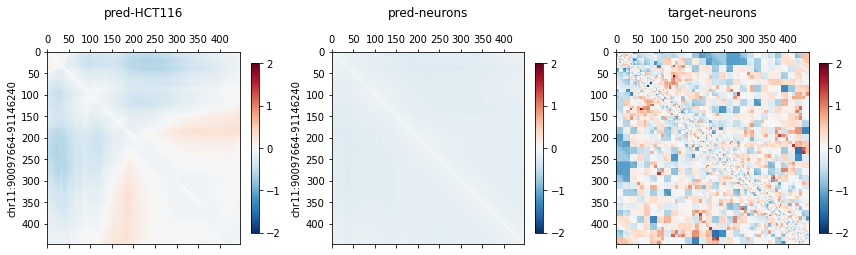

 
chr15:42508288-43556864


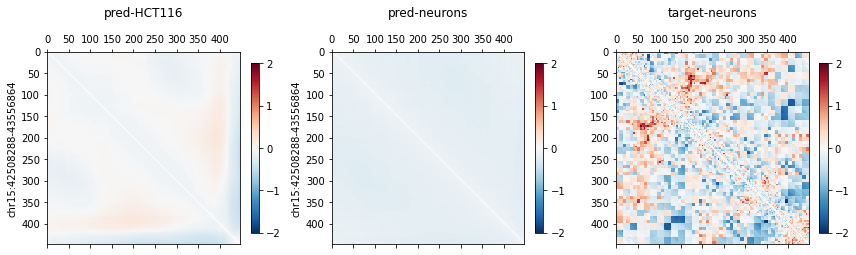

In [29]:
### make predictions and plot the three examples above ###
hic_num_to_name_dict = dict(zip(hic_targets['index'].values, hic_targets['identifier'].values) )
target_index = 4 # HCT116 

for test_index in fig2_inds:
    chrm, seq_start, seq_end = sequences_test.iloc[test_index][0:3]
    myseq_str = chrm+':'+str(seq_start)+'-'+str(seq_end)
    print(' ')
    print(myseq_str)
    
    test_target = test_targets[test_index:test_index+1,:]
    test_pred = pred['preds'][test_index:test_index+1,:,:]
    test_predf = predf['pred_final'][test_index:test_index+1,:]

    plt.figure(figsize=(12,4))
    vmin=-2; vmax=2

    # plot pred HCT116
    plt.subplot(131) 
    mat = from_upper_triu(test_pred[:,:,target_index], target_length_cropped, hic_diags)
    im = plt.matshow(mat, fignum=False, cmap= 'RdBu_r', vmax=vmax, vmin=vmin)
    plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2]);
    plt.title('pred-'+str(hic_num_to_name_dict[target_index]),y=1.15 )
    plt.ylabel(myseq_str)
    
    # plot pred neurons
    plt.subplot(132) 
    mat = from_upper_triu(test_predf[:,:], target_length_cropped, hic_diags)
    im = plt.matshow(mat, fignum=False, cmap= 'RdBu_r', vmax=vmax, vmin=vmin)
    plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2]);
    plt.title('pred-neurons',y=1.15 )
    plt.ylabel(myseq_str)
    

    # plot target 
    plt.subplot(133) 
    mat = from_upper_triu(test_target[:,:], target_length_cropped, hic_diags)
    im = plt.matshow(mat, fignum=False, cmap= 'RdBu_r', vmax=vmax, vmin=vmin)
    plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2]);
    plt.title( 'target-neurons',y=1.15)

    plt.tight_layout()
    plt.show()